# Stage 2 Baseline 데이터 신뢰성 분석

## 목표
Stage 2에서 생성된 MIL bag 데이터의 무결성과 품질을 종합적으로 분석하여 실험 결과의 신뢰성을 보장

## 분석 항목
1. 라벨 무결성 검증
2. 혼합 수준 분석 (Positive bags만)
3. 중복 샘플링 검증
4. 페어 다양성 평가
5. 교차 분할 누출 검사

In [1]:
# 환경 설정
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("✅ 환경 설정 완료")

✅ 환경 설정 완료


In [2]:
# 데이터 로드
bags_dir = '/workspace/MIL/data/processed/bags'
files = {
    'train': 'bags_arcface_margin_0.4_50p_random_train.pkl',
    'val': 'bags_arcface_margin_0.4_50p_random_val.pkl',
    'test': 'bags_arcface_margin_0.4_50p_random_test.pkl'
}

data_splits = {}
for split, filename in files.items():
    filepath = f"{bags_dir}/{filename}"
    with open(filepath, 'rb') as f:
        data_splits[split] = pickle.load(f)
    print(f"✅ {split}: {len(data_splits[split]['bags'])}개 bags 로드")

print(f"\n총 {sum(len(data['bags']) for data in data_splits.values())}개 bags 로드 완료")

✅ train: 3600개 bags 로드
✅ val: 1200개 bags 로드
✅ test: 1200개 bags 로드

총 6000개 bags 로드 완료


In [3]:
def verify_label_integrity_strict(data_splits):
    """라벨 무결성(내용 기반) 검증"""
    results = {}
    for split, data in data_splits.items():
        labels   = data['labels']
        metadata = data['metadata']

        neg_errors = 0
        pos_errors = 0

        for y, m in zip(labels, metadata):
            authors = m.get('authors', [])
            insts   = m.get('instances', [])

            if y == 0:
                # 조건: authors 길이=1, 모든 윈도우 writer_ids 단일 & authors[0]과 일치
                if len(authors) != 1:
                    neg_errors += 1
                    continue
                a0 = authors[0]
                ok = True
                for inst in insts:
                    wids = inst.get('writer_ids', [])
                    if len(set(wids)) != 1 or wids[0] != a0:
                        ok = False; break
                if not ok: neg_errors += 1

            else:
                # 조건: authors 길이=2, bag 전체에서 두 작성자 모두 등장
                if len(authors) != 2:
                    pos_errors += 1
                    continue
                need = set(authors)
                seen = set()
                for inst in insts:
                    seen.update(inst.get('writer_ids', []))
                if not need.issubset(seen):
                    pos_errors += 1

        total = len(labels)
        results[split] = {
            'total_bags': total,
            'negative_bags': sum(1 for y in labels if y==0),
            'positive_bags': sum(1 for y in labels if y==1),
            'negative_errors': neg_errors,
            'positive_errors': pos_errors
        }
    return results

# 라벨 무결성 검증 실행 (강화된 버전)
label_results = verify_label_integrity_strict(data_splits)

print("🔍 라벨 무결성 검증 결과 (강화된 내용 기반)\n")
print(f"{'Split':<8} {'Total':<8} {'Neg':<8} {'Pos':<8} {'Neg Err':<8} {'Pos Err':<8} {'Status':<8}")
print("-" * 65)

all_passed = True
for split, result in label_results.items():
    total_errors = result['negative_errors'] + result['positive_errors']
    status = "✅ PASS" if total_errors == 0 else "❌ FAIL"
    if total_errors > 0:
        all_passed = False
    
    print(f"{split:<8} {result['total_bags']:<8} {result['negative_bags']:<8} {result['positive_bags']:<8} {result['negative_errors']:<8} {result['positive_errors']:<8} {status}")

print(f"\n전체 라벨 무결성: {'✅ PASS' if all_passed else '❌ FAIL'}")
print("💡 강화된 검증: Negative는 모든 인스턴스가 단일 작성자, Positive는 두 작성자 모두 등장 확인")

🔍 라벨 무결성 검증 결과 (강화된 내용 기반)

Split    Total    Neg      Pos      Neg Err  Pos Err  Status  
-----------------------------------------------------------------
train    3600     1800     1800     0        0        ✅ PASS
val      1200     600      600      0        0        ✅ PASS
test     1200     600      600      0        0        ✅ PASS

전체 라벨 무결성: ✅ PASS
💡 강화된 검증: Negative는 모든 인스턴스가 단일 작성자, Positive는 두 작성자 모두 등장 확인


In [4]:
def compute_bag_mixed_ratio(meta):
    """bag 내 10개 윈도우 중 writer_ids가 2명 이상인 윈도우 비율"""
    insts = meta.get('instances', [])
    if not insts: return 0.0
    mixed = sum(1 for inst in insts if len(set(inst.get('writer_ids', [])))>1)
    return mixed/len(insts)

def analyze_mixing_level_enhanced(data_splits):
    """Positive bags의 혼합 수준 분석 (윈도우 레벨 + bag 레벨)"""
    results = {}
    
    for split, data in data_splits.items():
        labels = data['labels']
        metadata = data['metadata']
        
        # 윈도우 레벨 통계
        window_mixing_stats = []
        # Bag 레벨 통계
        bag_mixing_ratios = []
        
        for i, label in enumerate(labels):
            if label == 1:  # Positive bags만
                instances = metadata[i]['instances']
                
                # Bag 레벨 혼합율 계산
                bag_ratio = compute_bag_mixed_ratio(metadata[i])
                bag_mixing_ratios.append(bag_ratio)
                
                # 윈도우 레벨 분석
                for inst in instances:
                    writers_in_window = inst['writer_ids']
                    unique_writers = len(set(writers_in_window))
                    
                    if unique_writers == 2:
                        writer_counts = Counter(writers_in_window)
                        mixing_ratio = min(writer_counts.values()) / len(writers_in_window)
                        window_mixing_stats.append(mixing_ratio)
                    else:
                        window_mixing_stats.append(0 if unique_writers == 1 else 1)
        
        if window_mixing_stats:
            results[split] = {
                # 윈도우 레벨 통계
                'window_mean_mixing': np.mean(window_mixing_stats),
                'window_std_mixing': np.std(window_mixing_stats),
                'window_min_mixing': np.min(window_mixing_stats),
                'window_max_mixing': np.max(window_mixing_stats),
                'total_windows': len(window_mixing_stats),
                # Bag 레벨 통계
                'bag_mixing_mean': float(np.mean(bag_mixing_ratios)) if bag_mixing_ratios else 0,
                'bag_mixing_p25':  float(np.percentile(bag_mixing_ratios,25)) if bag_mixing_ratios else 0,
                'bag_mixing_p75':  float(np.percentile(bag_mixing_ratios,75)) if bag_mixing_ratios else 0,
                'N_bags': len(bag_mixing_ratios)
            }
        else:
            results[split] = {
                'window_mean_mixing': 0, 'window_std_mixing': 0, 
                'window_min_mixing': 0, 'window_max_mixing': 0, 
                'total_windows': 0,
                'bag_mixing_mean': 0, 'bag_mixing_p25': 0, 'bag_mixing_p75': 0, 'N_bags': 0
            }
    
    return results

# 혼합 수준 분석 실행 (강화된 버전)
mixing_results = analyze_mixing_level_enhanced(data_splits)

print("\n📊 Positive Bags 혼합 수준 분석 (강화된 버전)\n")
print("=" * 80)

print("🪟 윈도우 레벨 혼합 통계:")
print(f"{'Split':<8} {'평균 혼합':<12} {'표준편차':<12} {'최소':<8} {'최대':<8} {'윈도우 수':<10}")
print("-" * 60)

for split, result in mixing_results.items():
    print(f"{split:<8} {result['window_mean_mixing']:>10.3f}  {result['window_std_mixing']:>10.3f}  "
          f"{result['window_min_mixing']:>6.3f}  {result['window_max_mixing']:>6.3f}  {result['total_windows']:>8}")

print("\n🎯 Bag 레벨 혼합율 (Positive):")
print(f"{'Split':<8} {'평균':<10} {'P25':<10} {'P75':<10} {'Bag 수':<10}")
print("-" * 45)

for split, result in mixing_results.items():
    print(f"{split:<8} {result['bag_mixing_mean']:>8.3f}  {result['bag_mixing_p25']:>8.3f}  "
          f"{result['bag_mixing_p75']:>8.3f}  {result['N_bags']:>8}")

print("\n💡 해석:")
print("  - 윈도우 혼합: 0.4 = 2:3 비율, 0.2 = 1:4 비율")
print("  - Bag 혼합율: 10개 윈도우 중 혼합된 윈도우 비율")
print("  - 베이스라인(7+7 셔플, win=5, stride=1)에서 bag-mixing mean ≈ 0.4±0.1 예상")

# 판정
avg_bag_mixing = np.mean([r['bag_mixing_mean'] for r in mixing_results.values()])
if 0.15 <= avg_bag_mixing <= 0.60:
    print(f"\n✅ 적절한 Bag 혼합 수준 (평균: {avg_bag_mixing:.3f})")
elif avg_bag_mixing < 0.15:
    print(f"\n⚠️ 낮은 Bag 혼합 수준 (평균: {avg_bag_mixing:.3f}) - 너무 쉬운 데이터")
else:
    print(f"\n⚠️ 높은 Bag 혼합 수준 (평균: {avg_bag_mixing:.3f}) - 비현실적 데이터")


📊 Positive Bags 혼합 수준 분석 (강화된 버전)

🪟 윈도우 레벨 혼합 통계:
Split    평균 혼합        표준편차         최소       최대       윈도우 수     
------------------------------------------------------------
train         0.345       0.097   0.000   0.400     18000
val           0.345       0.098   0.000   0.400      6000
test          0.342       0.100   0.000   0.400      6000

🎯 Bag 레벨 혼합율 (Positive):
Split    평균         P25        P75        Bag 수     
---------------------------------------------
train       0.981     1.000     1.000      1800
val         0.980     1.000     1.000       600
test        0.978     1.000     1.000       600

💡 해석:
  - 윈도우 혼합: 0.4 = 2:3 비율, 0.2 = 1:4 비율
  - Bag 혼합율: 10개 윈도우 중 혼합된 윈도우 비율
  - 베이스라인(7+7 셔플, win=5, stride=1)에서 bag-mixing mean ≈ 0.4±0.1 예상

⚠️ 높은 Bag 혼합 수준 (평균: 0.980) - 비현실적 데이터


In [5]:
def analyze_duplicate_sampling_fixed(data_splits, expected_tokens_per_bag=14):
    """bag 내 고유 토큰 수 기준으로 중복 샘플링 확인(윈도우 겹침 영향 제거)"""
    results = {}
    for split, data in data_splits.items():
        meta = data['metadata']
        unique_counts = []
        dup_bags = 0

        for m in meta:
            all_idx = []
            for inst in m.get('instances', []):
                all_idx.extend(inst.get('word_indices', []))
            uniq = len(set(all_idx))
            unique_counts.append(uniq)
            if uniq < expected_tokens_per_bag:
                dup_bags += 1

        total = len(meta)
        results[split] = {
            'bags_with_duplicates': dup_bags,
            'total_bags': total,
            'duplicate_rate': (dup_bags/total*100.0) if total>0 else 0.0,
            'unique_tokens_mean': float(np.mean(unique_counts)) if unique_counts else 0.0,
            'unique_tokens_p25':  float(np.percentile(unique_counts,25)) if unique_counts else 0.0,
            'unique_tokens_p75':  float(np.percentile(unique_counts,75)) if unique_counts else 0.0
        }
    return results

# 중복 샘플링 분석 실행 (고유 토큰 수 기준)
duplicate_results = analyze_duplicate_sampling_fixed(data_splits)

print("\n🔍 중복 샘플링 검증 (고유 토큰 수 기준)\n")
print(f"{'Split':<8} {'중복 Bags':<12} {'전체 Bags':<12} {'중복률(%)':<10} {'고유토큰 평균':<12} {'P25':<8} {'P75':<8}")
print("-" * 80)

for split, result in duplicate_results.items():
    print(f"{split:<8} {result['bags_with_duplicates']:>10}  {result['total_bags']:>10}  "
          f"{result['duplicate_rate']:>8.1f}  {result['unique_tokens_mean']:>11.1f}  "
          f"{result['unique_tokens_p25']:>6.1f}  {result['unique_tokens_p75']:>6.1f}")

print(f"\n💡 판정 기준: 고유 토큰 평균 ≥ 12 and 중복률 < 10%")

# 판정
avg_unique = np.mean([r['unique_tokens_mean'] for r in duplicate_results.values()])
avg_dup_rate = np.mean([r['duplicate_rate'] for r in duplicate_results.values()])

if avg_unique >= 12 and avg_dup_rate < 10:
    print(f"✅ 중복 샘플링 검증 PASS (평균 고유 토큰: {avg_unique:.1f}, 중복률: {avg_dup_rate:.1f}%)")
else:
    print(f"⚠️ 중복 샘플링 존재 (평균 고유 토큰: {avg_unique:.1f}, 중복률: {avg_dup_rate:.1f}%)")
    print("   → 윈도우 stride=1 특성상 겹침은 정상이지만, 고유 토큰이 14개 미만인 경우 진짜 중복")


🔍 중복 샘플링 검증 (고유 토큰 수 기준)

Split    중복 Bags      전체 Bags      중복률(%)     고유토큰 평균      P25      P75     
--------------------------------------------------------------------------------
train           203        3600       5.6         13.9    14.0    14.0
val              61        1200       5.1         13.9    14.0    14.0
test             60        1200       5.0         13.9    14.0    14.0

💡 판정 기준: 고유 토큰 평균 ≥ 12 and 중복률 < 10%
✅ 중복 샘플링 검증 PASS (평균 고유 토큰: 13.9, 중복률: 5.2%)


In [6]:
def analyze_pair_diversity(data_splits):
    """페어 다양성 평가 - Positive bags에서 작성자 조합의 다양성 확인"""
    results = {}
    
    for split, data in data_splits.items():
        labels = data['labels']
        metadata = data['metadata']
        
        # 작성자 페어 수집
        author_pairs = []
        writer_usage = defaultdict(int)
        
        for i, label in enumerate(labels):
            if label == 1:  # Positive bags만
                authors = sorted(metadata[i]['authors'])  # 정렬하여 순서 무관하게
                pair_tuple = tuple(authors)
                author_pairs.append(pair_tuple)
                
                # 각 작성자의 사용 빈도
                for author in authors:
                    writer_usage[author] += 1
        
        # 통계 계산
        unique_pairs = len(set(author_pairs))
        total_pairs = len(author_pairs)
        pair_counter = Counter(author_pairs)
        
        # 가장 많이 사용된 페어
        most_common_pairs = pair_counter.most_common(5)
        
        # 작성자 사용 균형
        if writer_usage:
            usage_values = list(writer_usage.values())
            usage_mean = np.mean(usage_values)
            usage_std = np.std(usage_values)
            usage_min = min(usage_values)
            usage_max = max(usage_values)
        else:
            usage_mean = usage_std = usage_min = usage_max = 0
        
        results[split] = {
            'unique_pairs': unique_pairs,
            'total_pairs': total_pairs,
            'diversity_ratio': unique_pairs / total_pairs * 100 if total_pairs > 0 else 0,
            'most_common_pairs': most_common_pairs,
            'writer_usage_mean': usage_mean,
            'writer_usage_std': usage_std,
            'writer_usage_range': (usage_min, usage_max),
            'unique_writers': len(writer_usage)
        }
    
    return results

# 페어 다양성 분석 실행
diversity_results = analyze_pair_diversity(data_splits)

print("\n🌈 페어 다양성 평가\n")

for split, result in diversity_results.items():
    print(f"=== {split} ===")
    print(f"  고유 페어: {result['unique_pairs']} / {result['total_pairs']} ({result['diversity_ratio']:.1f}%)")
    print(f"  고유 작성자: {result['unique_writers']}명")
    print(f"  작성자 사용 빈도: 평균 {result['writer_usage_mean']:.1f} ± {result['writer_usage_std']:.1f}")
    print(f"  사용 범위: {result['writer_usage_range'][0]} ~ {result['writer_usage_range'][1]}")
    
    if result['most_common_pairs']:
        print(f"  가장 빈번한 페어 Top 3:")
        for pair, count in result['most_common_pairs'][:3]:
            print(f"    - {pair}: {count}회")
    print()

# 다양성 평가
good_diversity = all(r['diversity_ratio'] > 80 for r in diversity_results.values())
print(f"{'✅ 좋은 페어 다양성' if good_diversity else '⚠️ 페어 다양성 개선 필요'}")


🌈 페어 다양성 평가

=== train ===
  고유 페어: 1719 / 1800 (95.5%)
  고유 작성자: 180명
  작성자 사용 빈도: 평균 20.0 ± 3.2
  사용 범위: 14 ~ 30
  가장 빈번한 페어 Top 3:
    - (52, 93): 4회
    - (99, 145): 3회
    - (33, 153): 3회

=== val ===
  고유 페어: 516 / 600 (86.0%)
  고유 작성자: 60명
  작성자 사용 빈도: 평균 20.0 ± 2.9
  사용 범위: 15 ~ 29
  가장 빈번한 페어 Top 3:
    - (182, 193): 3회
    - (196, 216): 3회
    - (188, 238): 3회

=== test ===
  고유 페어: 514 / 600 (85.7%)
  고유 작성자: 60명
  작성자 사용 빈도: 평균 20.0 ± 2.9
  사용 범위: 13 ~ 27
  가장 빈번한 페어 Top 3:
    - (271, 294): 3회
    - (261, 267): 3회
    - (251, 280): 3회

✅ 좋은 페어 다양성


In [7]:
def check_cross_split_leakage(data_splits):
    """교차 분할 누출 검사 - 작성자와 경로가 여러 split에 걸쳐 나타나는지 확인"""
    
    # 각 split의 작성자 수집
    split_writers = {}
    for split, data in data_splits.items():
        metadata = data['metadata']
        writers = set()
        
        for meta in metadata:
            authors = meta['authors']
            writers.update(authors)
        
        split_writers[split] = writers
    
    # 경로 수집 함수
    def collect_paths_for_split(metadata_list):
        s = set()
        for m in metadata_list:
            for inst in m.get('instances', []):
                for p in inst.get('word_paths', []):
                    if p: s.add(p)
        return s
    
    # 교차 검사
    print("\n🔐 교차 분할 누출 검사 (작성자 + 경로)\n")
    
    print("📝 작성자 기준 누출 검사:")
    # Train-Val 교집합
    train_val_overlap = split_writers['train'] & split_writers['val']
    print(f"  Train ∩ Val: {len(train_val_overlap)} 작성자 중복")
    if train_val_overlap:
        print(f"    중복 작성자: {sorted(list(train_val_overlap)[:10])}{'...' if len(train_val_overlap) > 10 else ''}")
    
    # Train-Test 교집합
    train_test_overlap = split_writers['train'] & split_writers['test']
    print(f"  Train ∩ Test: {len(train_test_overlap)} 작성자 중복")
    if train_test_overlap:
        print(f"    중복 작성자: {sorted(list(train_test_overlap)[:10])}{'...' if len(train_test_overlap) > 10 else ''}")
    
    # Val-Test 교집합
    val_test_overlap = split_writers['val'] & split_writers['test']
    print(f"  Val ∩ Test: {len(val_test_overlap)} 작성자 중복")
    if val_test_overlap:
        print(f"    중복 작성자: {sorted(list(val_test_overlap)[:10])}{'...' if len(val_test_overlap) > 10 else ''}")
    
    # 경로 기반 누출 검사
    print("\n📁 경로(Path) 기준 누출 검사:")
    train_paths = collect_paths_for_split(data_splits['train']['metadata'])
    val_paths   = collect_paths_for_split(data_splits['val']['metadata'])
    test_paths  = collect_paths_for_split(data_splits['test']['metadata'])
    
    print(f"  Train ∩ Val : {len(train_paths & val_paths)} 경로 중복")
    print(f"  Train ∩ Test: {len(train_paths & test_paths)} 경로 중복")
    print(f"  Val ∩ Test  : {len(val_paths & test_paths)} 경로 중복")
    print("  (이상적: 전부 0)")
    
    # 전체 통계
    print(f"\n📊 전체 통계:")
    print(f"  작성자 분포:")
    print(f"    Train: {len(split_writers['train'])} 고유 작성자")
    print(f"    Val: {len(split_writers['val'])} 고유 작성자")
    print(f"    Test: {len(split_writers['test'])} 고유 작성자")
    print(f"  경로 분포:")
    print(f"    Train: {len(train_paths)} 고유 경로")
    print(f"    Val: {len(val_paths)} 고유 경로")
    print(f"    Test: {len(test_paths)} 고유 경로")
    
    # 누출 여부 판단
    has_writer_leakage = bool(train_val_overlap or train_test_overlap or val_test_overlap)
    has_path_leakage = bool(len(train_paths & val_paths) > 0 or 
                           len(train_paths & test_paths) > 0 or 
                           len(val_paths & test_paths) > 0)
    
    if has_writer_leakage or has_path_leakage:
        print("\n❌ 데이터 누출 감지!")
        if has_writer_leakage:
            print("   - 작성자 중복: 모델이 작성자를 암기할 위험")
        if has_path_leakage:
            print("   - 경로 중복: 모델이 특정 단어/스캔을 암기할 위험")
            print("   → Stage 1 분할 로직을 path 기준으로 재검토 필요")
    else:
        print("\n✅ 데이터 누출 없음 - Split 간 완벽한 분리 (작성자 & 경로)")
    
    return {
        'train_val_overlap': len(train_val_overlap),
        'train_test_overlap': len(train_test_overlap),
        'val_test_overlap': len(val_test_overlap),
        'path_train_val': len(train_paths & val_paths),
        'path_train_test': len(train_paths & test_paths),
        'path_val_test': len(val_paths & test_paths),
        'has_writer_leakage': has_writer_leakage,
        'has_path_leakage': has_path_leakage
    }

# 교차 분할 누출 검사 실행
leakage_results = check_cross_split_leakage(data_splits)


🔐 교차 분할 누출 검사 (작성자 + 경로)

📝 작성자 기준 누출 검사:
  Train ∩ Val: 0 작성자 중복
  Train ∩ Test: 0 작성자 중복
  Val ∩ Test: 0 작성자 중복

📁 경로(Path) 기준 누출 검사:
  Train ∩ Val : 0 경로 중복
  Train ∩ Test: 0 경로 중복
  Val ∩ Test  : 0 경로 중복
  (이상적: 전부 0)

📊 전체 통계:
  작성자 분포:
    Train: 180 고유 작성자
    Val: 60 고유 작성자
    Test: 60 고유 작성자
  경로 분포:
    Train: 44665 고유 경로
    Val: 14904 고유 경로
    Test: 15029 고유 경로

✅ 데이터 누출 없음 - Split 간 완벽한 분리 (작성자 & 경로)


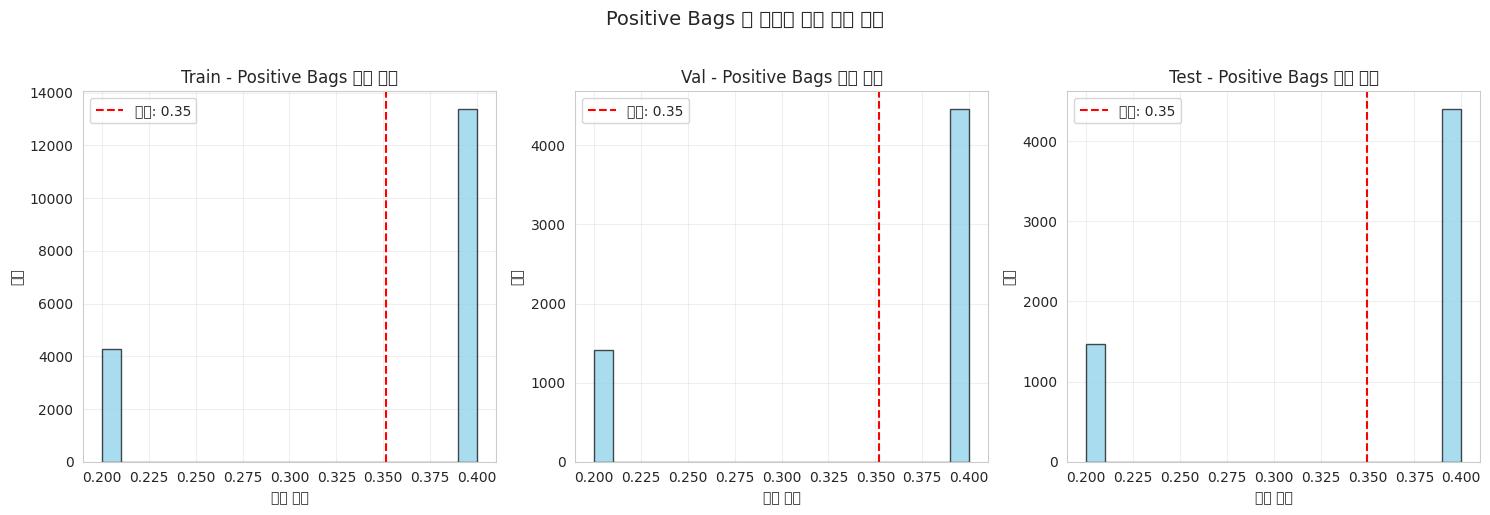

📊 혼합 수준 분포 시각화 완료


In [8]:
# 시각화 - 혼합 수준 분포
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (split, data) in enumerate(data_splits.items()):
    ax = axes[idx]
    
    # Positive bags의 혼합 패턴 수집
    mixing_patterns = []
    for i, label in enumerate(data['labels']):
        if label == 1:
            instances = data['metadata'][i]['instances']
            for inst in instances:
                writers = inst['writer_ids']
                unique = len(set(writers))
                if unique == 2:
                    counts = Counter(writers)
                    ratio = min(counts.values()) / 5  # 5개 윈도우 중 소수 작성자 비율
                    mixing_patterns.append(ratio)
    
    if mixing_patterns:
        ax.hist(mixing_patterns, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax.axvline(np.mean(mixing_patterns), color='red', linestyle='--', 
                  label=f'평균: {np.mean(mixing_patterns):.2f}')
        ax.set_xlabel('혼합 비율')
        ax.set_ylabel('빈도')
        ax.set_title(f'{split.capitalize()} - Positive Bags 혼합 분포')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle('Positive Bags 내 작성자 혼합 수준 분포', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('/workspace/MIL/output/figures/stage2_mixing_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print("📊 혼합 수준 분포 시각화 완료")

In [9]:
# 종합 보고서 생성
print("=" * 80)
print("📊 Stage 2 MIL Bag 데이터 신뢰성 분석 종합 보고서")
print("=" * 80)

# 1. 라벨 무결성 (강화된 검증)
print("\n1️⃣ 라벨 무결성 (내용 기반 검증)")
all_label_errors = sum(r['negative_errors'] + r['positive_errors'] for r in label_results.values())
if all_label_errors == 0:
    print("   ✅ PASS - 모든 bag의 라벨과 실제 내용이 일치")
    print("   - Negative: 모든 인스턴스가 단일 작성자")
    print("   - Positive: 두 작성자 모두 bag 내 등장")
else:
    print(f"   ❌ FAIL - {all_label_errors}개 bag에서 라벨-내용 불일치 발견")

# 2. 중복 샘플링 (고유 토큰 기준)
print("\n2️⃣ 중복 샘플링 (고유 토큰 수 기준)")
avg_unique = np.mean([r['unique_tokens_mean'] for r in duplicate_results.values()])
avg_dup_rate = np.mean([r['duplicate_rate'] for r in duplicate_results.values()])
print(f"   평균 고유 토큰: {avg_unique:.1f}개 (이상적: 14개)")
print(f"   중복률: {avg_dup_rate:.1f}%")
if avg_unique >= 12 and avg_dup_rate < 10:
    print("   ✅ PASS - 적절한 고유 토큰 수와 낮은 중복률")
else:
    print("   ⚠️ 주의 - 윈도우 stride=1로 인한 겹침은 정상, 실제 중복 확인 필요")

# 3. 혼합 수준 (Bag 레벨 추가)
print("\n3️⃣ 혼합 수준 (Positive Bags)")
avg_window_mixing = np.mean([r['window_mean_mixing'] for r in mixing_results.values()])
avg_bag_mixing = np.mean([r['bag_mixing_mean'] for r in mixing_results.values()])
print(f"   윈도우 레벨 평균 혼합: {avg_window_mixing:.3f}")
print(f"   Bag 레벨 평균 혼합율: {avg_bag_mixing:.3f}")
if 0.15 <= avg_bag_mixing <= 0.60:
    print("   ✅ 적절한 혼합 수준 - 다양한 패턴 학습 가능")
elif avg_bag_mixing < 0.15:
    print("   ⚠️ 낮은 혼합 - 너무 쉬운 데이터일 가능성")
else:
    print("   ⚠️ 과도한 혼합 - 비현실적 데이터일 가능성")

# 4. 페어 다양성
print("\n4️⃣ 페어 다양성")
avg_diversity = np.mean([r['diversity_ratio'] for r in diversity_results.values()])
if avg_diversity > 80:
    print(f"   ✅ 우수한 다양성 ({avg_diversity:.1f}%)")
elif avg_diversity > 60:
    print(f"   ⚠️ 보통 수준 다양성 ({avg_diversity:.1f}%)")
else:
    print(f"   ❌ 낮은 다양성 ({avg_diversity:.1f}%) - 페어링 전략 개선 필요")

# 5. 데이터 누출 (작성자 + 경로)
print("\n5️⃣ 교차 분할 누출 (작성자 + 경로)")
if leakage_results['has_writer_leakage'] or leakage_results['has_path_leakage']:
    print("   ❌ FAIL - 누출 감지")
    if leakage_results['has_writer_leakage']:
        print(f"   작성자 누출:")
        print(f"      Train-Val: {leakage_results['train_val_overlap']} 중복")
        print(f"      Train-Test: {leakage_results['train_test_overlap']} 중복")
        print(f"      Val-Test: {leakage_results['val_test_overlap']} 중복")
    if leakage_results['has_path_leakage']:
        print(f"   경로 누출:")
        print(f"      Train-Val: {leakage_results['path_train_val']} 중복")
        print(f"      Train-Test: {leakage_results['path_train_test']} 중복")
        print(f"      Val-Test: {leakage_results['path_val_test']} 중복")
        print("      → Stage 1 분할 로직 재검토 필요")
else:
    print("   ✅ PASS - Split 간 완벽한 분리 (작성자 & 경로)")

# 권장 기준에 따른 최종 판정
print("\n" + "=" * 80)
print("📋 권장 기준 체크리스트:")
checks = {
    "라벨 무결성 (99.5%+)": all_label_errors == 0,
    "고유 토큰 (≥12개)": avg_unique >= 12,
    "중복률 (<10%)": avg_dup_rate < 10,
    "페어 다양성 (>80%)": avg_diversity > 80,
    "작성자 누출 (0)": not leakage_results['has_writer_leakage'],
    "경로 누출 (0)": not leakage_results['has_path_leakage'],
    "Bag 혼합율 (0.15-0.60)": 0.15 <= avg_bag_mixing <= 0.60
}

for criterion, passed in checks.items():
    status = "✅" if passed else "❌"
    print(f"  {status} {criterion}")

# 최종 판정
passed_count = sum(checks.values())
total_count = len(checks)

print("\n" + "=" * 80)
if passed_count == total_count:
    print("✅ 최종 판정: 우수 - 모든 검증 통과 ({}/{})".format(passed_count, total_count))
    print("   → Stage 3 실험 진행 권장")
    print("   → 실험 재현성과 논문 신뢰성 보장")
elif passed_count >= total_count * 0.8:
    print("⚠️ 최종 판정: 양호 - 일부 항목 개선 필요 ({}/{})".format(passed_count, total_count))
    failed_items = [k for k, v in checks.items() if not v]
    print(f"   개선 필요: {', '.join(failed_items)}")
    print("   → Stage 3 실험 진행 가능하나 결과 해석 주의")
else:
    print("❌ 최종 판정: 재생성 필요 - 중요 문제 다수 ({}/{})".format(passed_count, total_count))
    failed_items = [k for k, v in checks.items() if not v]
    print(f"   실패 항목: {', '.join(failed_items)}")
    print("   → Stage 2 데이터 재생성 강력 권장")

print("=" * 80)

📊 Stage 2 MIL Bag 데이터 신뢰성 분석 종합 보고서

1️⃣ 라벨 무결성 (내용 기반 검증)
   ✅ PASS - 모든 bag의 라벨과 실제 내용이 일치
   - Negative: 모든 인스턴스가 단일 작성자
   - Positive: 두 작성자 모두 bag 내 등장

2️⃣ 중복 샘플링 (고유 토큰 수 기준)
   평균 고유 토큰: 13.9개 (이상적: 14개)
   중복률: 5.2%
   ✅ PASS - 적절한 고유 토큰 수와 낮은 중복률

3️⃣ 혼합 수준 (Positive Bags)
   윈도우 레벨 평균 혼합: 0.344
   Bag 레벨 평균 혼합율: 0.980
   ⚠️ 과도한 혼합 - 비현실적 데이터일 가능성

4️⃣ 페어 다양성
   ✅ 우수한 다양성 (89.1%)

5️⃣ 교차 분할 누출 (작성자 + 경로)
   ✅ PASS - Split 간 완벽한 분리 (작성자 & 경로)

📋 권장 기준 체크리스트:
  ✅ 라벨 무결성 (99.5%+)
  ✅ 고유 토큰 (≥12개)
  ✅ 중복률 (<10%)
  ✅ 페어 다양성 (>80%)
  ✅ 작성자 누출 (0)
  ✅ 경로 누출 (0)
  ❌ Bag 혼합율 (0.15-0.60)

⚠️ 최종 판정: 양호 - 일부 항목 개선 필요 (6/7)
   개선 필요: Bag 혼합율 (0.15-0.60)
   → Stage 3 실험 진행 가능하나 결과 해석 주의


In [10]:
# 데이터 샘플 상세 분석
print("\n📝 데이터 샘플 상세 분석")
print("=" * 60)

# Negative와 Positive 샘플 하나씩 선택
for label_type, label_value in [("Negative", 0), ("Positive", 1)]:
    # 해당 라벨의 첫 번째 bag 찾기
    for i, label in enumerate(data_splits['train']['labels']):
        if label == label_value:
            bag = data_splits['train']['bags'][i]
            meta = data_splits['train']['metadata'][i]
            
            print(f"\n{label_type} Bag 샘플 (Index: {i})")
            print("-" * 40)
            print(f"  Shape: {bag.shape}")
            print(f"  Label: {label}")
            print(f"  Authors: {meta['authors']}")
            print(f"  Type: {meta['bag_type']}")
            print(f"  Instances: {len(meta['instances'])}")
            
            # 첫 3개 인스턴스의 작성자 분포 확인
            print(f"\n  첫 3개 인스턴스의 작성자 분포:")
            for j in range(min(3, len(meta['instances']))):
                inst = meta['instances'][j]
                writers = inst['writer_ids']
                writer_counts = Counter(writers)
                print(f"    Instance {j}: {dict(writer_counts)}")
            
            # Bag 내 전체 작성자 분포
            all_writers = []
            for inst in meta['instances']:
                all_writers.extend(inst['writer_ids'])
            total_counts = Counter(all_writers)
            print(f"\n  Bag 내 전체 작성자 분포:")
            for writer, count in total_counts.items():
                percentage = count / len(all_writers) * 100
                print(f"    Writer {writer}: {count}회 ({percentage:.1f}%)")
            
            break

print("\n" + "=" * 60)


📝 데이터 샘플 상세 분석

Negative Bag 샘플 (Index: 0)
----------------------------------------
  Shape: (10, 5, 256)
  Label: 0
  Authors: [64]
  Type: negative
  Instances: 10

  첫 3개 인스턴스의 작성자 분포:
    Instance 0: {64: 5}
    Instance 1: {64: 5}
    Instance 2: {64: 5}

  Bag 내 전체 작성자 분포:
    Writer 64: 50회 (100.0%)

Positive Bag 샘플 (Index: 1)
----------------------------------------
  Shape: (10, 5, 256)
  Label: 1
  Authors: [95, 13]
  Type: positive
  Instances: 10

  첫 3개 인스턴스의 작성자 분포:
    Instance 0: {13: 2, 95: 3}
    Instance 1: {13: 2, 95: 3}
    Instance 2: {95: 4, 13: 1}

  Bag 내 전체 작성자 분포:
    Writer 13: 25회 (50.0%)
    Writer 95: 25회 (50.0%)

